In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import logging
import asyncio



sys.path.append('../')

from utils import Graph
from utils.visualization import plot_connections

graph = Graph('bolt://localhost:7687', 'neo4j', 'neo4jneo4j')

In [2]:
logging.basicConfig(filename='../data/logs/link_prediction.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)

In [3]:
#train sub graph
query = """
MATCH (a)-[r:SUPPLIES_TO]->(b) 
WHERE datetime(r.date).year < 2021
WITH a,b,r
MERGE (a)-[l:SUPPLIES_TO_TRAIN]-(b)
ON CREATE
    SET
        l.date = r.date,
        l.year = datetime(r.date).year, 
        l.distance = r.distance, 
        l.revenue_pct = r.revenue_pct
"""
graph.query_run(query, {})

[]


In [4]:
#validation sub graph
query = """
MATCH (a)-[r:SUPPLIES_TO]->(b) 
WHERE datetime(r.date).year >= 2021 AND datetime(r.date).year < 2022
WITH a,b,r
MERGE (a)-[l:SUPPLIES_TO_VALID]-(b)
ON CREATE
    SET
        l.date = r.date,
        l.year = datetime(r.date).year, 
        l.distance = r.distance, 
        l.revenue_pct = r.revenue_pct
"""
graph.query_run(query, {})

BufferError: Existing exports of data: object cannot be re-sized

In [ ]:
#test sub graph
query = """
MATCH (a)-[r:SUPPLIES_TO]->(b) 
WHERE datetime(r.date).year >= 2022
WITH a,b,r
MERGE (a)-[l:SUPPLIES_TO_TEST]-(b)
ON CREATE
    SET
        l.date = r.date,
        l.year = datetime(r.date).year, 
        l.distance = r.distance, 
        l.revenue_pct = r.revenue_pct
"""
graph.query_run(query, {})

[]


# Feature Engineering

In [ ]:
# def make_batch_run(func):

#     def wrapper(*args, **kwargs):

#         i = 0
#         for chunk in np.array_split(args[0], 500):

#             args1 = [chunk, args[1]]
            
#             new_data = func(*args1, **kwargs)

#             if i == 0:
#                 data = new_data
#             else:
#                 data = pd.concat([data, new_data])

#                 data.to_csv(func.__name__ + args[1].split('_')[-1] + 'data.csv', index = False)

#             i = i+1

#             logging.error(f'Chunk {i} done')

#     return wrapper

def make_batch_run(func):
    """
    A decorator that allows a function to process data in chunks.
    """
    def wrapper(*args, **kwargs):

        """
        The wrapper function that replaces the original function.
        """
        
        data = pd.DataFrame()

        for i, chunk in enumerate(np.array_split(args[0], 500)):

            args1 = [chunk, args[1]]
            new_data = func(*args1, **kwargs)
            data = pd.concat([data, new_data])
            logging.error(f'Chunk {i+1} done')

        data.to_csv('../data/processed/' + func.__name__ + args[1].split('_')[-1] + 'data.csv', index = False)

    return wrapper

In [ ]:
#TODO: parallelize with apoc.cypher.parallel2


@make_batch_run
def apply_graphy_features(data, rel_type):

    """
    This function takes a dataframe with two columns: node1 and node2
    and returns the same dataframe with the following columns added:
    - common neighbors
    - jaccard coefficient
    - adamic adar
    - resource allocation
    - preferential attachment
    - total neighbors
    
    Parameters
    ----------
    data : pandas.DataFrame
        A dataframe with two columns: node1 and node2
    rel_type : str
        The relationship type to use for the link prediction algorithms
        
    Returns
    -------
    pandas.DataFrame
        The same dataframe with the following columns added:
        - common neighbors
        - jaccard coefficient
        - adamic adar
        - resource allocation
        - preferential attachment
        - total neighbors

    """

    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Company) WHERE p1.id = pair.node1
    MATCH (p2:Company) WHERE p2.id = pair.node2
    RETURN pair.node1 AS node1,
        pair.node2 AS node2,
        gds.alpha.linkprediction.commonNeighbors(
            p1, p2, {relationshipQuery: $relType}) AS cn,
        gds.alpha.linkprediction.sameCommunity(
                p1, p2) AS sc,
        gds.alpha.linkprediction.adamicAdar(
                p1, p2, {relationshipQuery: $relType}) AS aa,
        gds.alpha.linkprediction.resourceAllocation(
                p1, p2, {relationshipQuery: $relType}) AS ra,
        gds.alpha.linkprediction.preferentialAttachment(
            p1, p2, {relationshipQuery: $relType}) AS pa,
        gds.alpha.linkprediction.totalNeighbors(
            p1, p2, {relationshipQuery: $relType}) AS tn
    """

    pairs = [{"node1": chunk.node1, "node2": chunk.node2} for _, chunk in data.iterrows()]

    params = {"pairs": pairs, "relType": rel_type}
    
    features = graph.query_run_df(query, params)

    # logging.error(features)

    new_data = pd.merge(data, features, on = ['node1', 'node2'])

    return new_data



In [ ]:
# We calculate the rfm features on the first node of the relationship - the supplier of the relationship
# Add the recency feature based on e^-\gamma t
# Add the frequency feature based on the number of interactions
# Add the monetary feature based on the revenue_pct

def create_rfm_features(df, dataset_type):
    """
    Create the rfm features for the nodes in the graph

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the node information
    dataset_type : str
        The type of dataset - train, validation or test

    Returns
    -------
    node_features : pandas.DataFrame
        The dataframe containing the node features
    
    """
    
    df['date'] = pd.to_datetime(df['date'])
    
    node_features = df.groupby('node1').agg(
        func = None,
        supply_rpct_max = pd.NamedAgg(column='revenue_pct', aggfunc='max'),
        supply_distance_max = pd.NamedAgg(column='distance', aggfunc='sum'),
        supply_count = pd.NamedAgg(column='node2', aggfunc='count'),
        supply_recency = pd.NamedAgg(column='date', aggfunc='max'),
    ).reset_index()

    node_features.replace('-999.0', np.nan, inplace=True)

    node_features['supply_rpct_max'] = node_features['supply_rpct_max'].astype('float')

    if dataset_type == 'train':
        end_date = pd.to_datetime('01-01-2021')
    if dataset_type == 'validation':
        end_date = pd.to_datetime('01-01-2022')
    if dataset_type == 'test':
        end_date = pd.to_datetime('01-01-2023')

    node_features['supply_recency'] = node_features['supply_recency'] - end_date
    node_features['supply_recency'] = np.exp(node_features['supply_recency'].dt.days)

    
    return node_features

In [ ]:
def local_nbhd_features(nodes_list):
    
    nbhd_features = pd.DataFrame()

    
    return nbhd_features

# Training set

In [ ]:
# Find positive examples
train_existing_links = graph.query_run_df("""
MATCH (n:Company)-[r:SUPPLIES_TO_TRAIN]-(p:Company)
RETURN n.id AS node1, p.id AS node2, 1 AS label, r.revenue_pct as revenue_pct, r.date as date, r.distance as distance
""",{})

In [ ]:
train_existing_links.drop_duplicates(inplace = True)
train_existing_links 

,node1,node2,label,revenue_pct,date,distance
0,379,50472,1,-999.0,2020-05-13,2.995114e+05
1,25161,50472,1,-999.0,2017-04-21,1.105532e+07
2,2103,50472,1,-999.0,2019-06-04,1.383407e+06
3,156418,282940,1,-999.0,2020-12-01,1.510492e+06
4,294923,282940,1,-999.0,2020-03-23,1.175445e+06
...,...,...,...,...,...,...
251143,124691,81229,1,-999.0,2020-11-26,1.144485e+07
251144,124691,102791,1,-999.0,2020-11-26,1.166974e+07
251145,124691,371047,1,-999.0,2020-11-26,1.161667e+07
251146,124691,176574,1,-999.0,2020-11-26,2.025804e+04


In [ ]:
# Find negative examples
nodes = list(train_existing_links['node1'].unique())

train_missing_links = graph.query_run_df("""
UNWIND $nodes AS node1
MATCH (n:Company) WHERE n.id = node1
CALL {
    WITH n
    MATCH (n:Company)-[r:SUPPLIES_TO_TRAIN*2..3]-(p:Company) WHERE not((n:Company)-[:SUPPLIES_TO_TRAIN]-(p:Company))
    RETURN p
    LIMIT 6
}
RETURN n.id AS node1, p.id as node2, 0 as label
""", {"nodes" : nodes})


# # Find negative examples
# train_missing_links = graph.query_run_df("""
# MATCH (a:Company)
# WHERE (a)-[:SUPPLIES_TRAIN]-()
# MATCH (a)-[:SUPPLIES_TRAIN*2..3]-(other)
# WHERE not((a)-[:SUPPLIES_TRAIN]-(other))
# RETURN id(a) AS node1, id(other) AS node2, 0 AS label
# LIMIT 10000
# """,{})

In [ ]:
train_missing_links.drop_duplicates(inplace = True)
train_missing_links 

,node1,node2,label
0,379,6713,0
1,379,25220,0
2,379,34137,0
3,379,308297,0
4,379,80961,0
...,...,...,...
296973,31804,293137,0
296974,31804,308149,0
296975,31804,21782,0
296976,31804,24680,0


In [ ]:
# Down sample negative examples
train_missing_links = train_missing_links.sample(
    n=len(train_existing_links))

In [ ]:
training_data = pd.concat([train_existing_links, train_missing_links], ignore_index=True)

In [ ]:
training_data = training_data[['node1', 'node2', 'label']]

In [ ]:
if 'apply_graphy_featuresTRAINdata.csv' not in os.listdir('../data/processed/'):
    training = apply_graphy_features(training_data, 'SUPPLIES_TO_TRAIN')
else:
    training = pd.read_csv('../data/processed/apply_graphy_featuresTRAINdata.csv')

In [ ]:
node_features = create_rfm_features(train_existing_links, 'train')

In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502296 entries, 0 to 502295
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   node1   502296 non-null  int64  
 1   node2   502296 non-null  int64  
 2   label   502296 non-null  int64  
 3   cn      502296 non-null  float64
 4   sc      502296 non-null  float64
 5   aa      502296 non-null  float64
 6   ra      502296 non-null  float64
 7   pa      502296 non-null  float64
 8   tn      502296 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 34.5 MB


In [ ]:
node_features['node1'] = node_features['node1'].astype(int)

In [ ]:
node_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52157 entries, 0 to 52156
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   node1                52157 non-null  int32  
 1   supply_rpct_max      544 non-null    float64
 2   supply_distance_max  52157 non-null  float64
 3   supply_count         52157 non-null  int64  
 4   supply_recency       52157 non-null  float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.8 MB


In [ ]:
training_data = training.merge(node_features, on='node1', how='left')

In [ ]:
training_data

,node1,node2,label,cn,sc,aa,ra,pa,tn,supply_rpct_max,supply_distance_max,supply_count,supply_recency
0,379,50472,1,1.0,0.0,0.211533,0.008850,189.0,65.0,11.1,3.210522e+08,63,1.670170e-05
1,25161,50472,1,0.0,0.0,0.000000,0.000000,294.0,101.0,100.0,6.895160e+08,98,1.670170e-05
2,2103,50472,1,1.0,0.0,0.241363,0.015873,339.0,115.0,NaN,7.712649e+08,113,3.442477e-14
3,156418,282940,1,1.0,0.0,0.157632,0.001757,65.0,17.0,NaN,2.630456e+07,5,3.442477e-14
4,294923,282940,1,0.0,0.0,0.000000,0.000000,91.0,20.0,NaN,1.588596e+07,7,5.521082e-42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502291,122499,249751,0,0.0,0.0,0.000000,0.000000,64.0,65.0,NaN,6.687360e+06,1,0.000000e+00
502292,357592,24478,0,0.0,0.0,0.000000,0.000000,30.0,31.0,NaN,6.574459e+06,1,5.945257e-148
502293,40077,308283,0,0.0,0.0,0.000000,0.000000,492.0,127.0,NaN,8.798942e+06,4,0.000000e+00
502294,225242,169271,0,0.0,0.0,0.000000,0.000000,152.0,78.0,NaN,3.245422e+06,2,9.357623e-14


In [ ]:
training_data.to_csv('../data/processed/train.csv', index=False)

# Validation Data

In [ ]:
# Find positive examples
validation_existing_links = graph.query_run_df("""
MATCH (n:Company)-[r:SUPPLIES_TO_VALID]-(p:Company)
RETURN n.id AS node1, p.id AS node2, 1 AS label, r.revenue_pct as revenue_pct, r.date as date, r.distance as distance
""",{})

validation_existing_links.drop_duplicates(inplace = True)
validation_existing_links 

,node1,node2,label,revenue_pct,date,distance
0,284339,50472,1,-999.0,2021-06-01,3.825426e+06
1,355169,50472,1,-999.0,2021-04-23,4.331080e+06
2,289787,313953,1,-999.0,2021-03-19,4.023660e+05
3,300884,313953,1,-999.0,2021-03-19,5.988390e+06
4,5889,313953,1,-999.0,2021-04-15,7.682965e+06
...,...,...,...,...,...,...
168571,19586,155885,1,-999.0,2021-05-19,5.661544e+04
168572,68128,185725,1,11.8,2021-08-25,7.944538e+06
168573,68128,307471,1,25.2,2021-08-25,1.037711e+05
168574,302421,310366,1,-999.0,2021-10-25,NaN


In [ ]:
# Find negative examples
nodes = list(validation_existing_links['node1'].unique())

validation_missing_links = graph.query_run_df("""
UNWIND $nodes AS node1
MATCH (n:Company) WHERE n.id = node1
CALL {
    WITH n
    MATCH (n:Company)-[r:SUPPLIES_TO_VALID*2..3]-(p:Company) WHERE not((n:Company)-[:SUPPLIES_TO_VALID]-(p:Company))
    RETURN p
    LIMIT 4
}
RETURN n.id AS node1, p.id as node2, 0 as label
""", {"nodes" : nodes})


# # Find negative examples
# train_missing_links = graph.query_run_df("""
# MATCH (a:Company)
# WHERE (a)-[:SUPPLIES_TRAIN]-()
# MATCH (a)-[:SUPPLIES_TRAIN*2..3]-(other)
# WHERE not((a)-[:SUPPLIES_TRAIN]-(other))
# RETURN id(a) AS node1, id(other) AS node2, 0 AS label
# LIMIT 10000
# """,{})

In [ ]:
validation_missing_links.drop_duplicates(inplace = True)
validation_missing_links 

,node1,node2,label
0,284339,355169,0
1,284339,353767,0
2,284339,25860,0
3,284339,26820,0
4,355169,284339,0
...,...,...,...
177085,135546,336915,0
177086,135546,310785,0
177087,135546,313919,0
177088,22926,95853,0


In [ ]:
# Down sample negative examples
validation_missing_links = validation_missing_links.sample(
    n=len(validation_existing_links))

In [ ]:
validation_data = pd.concat([validation_existing_links, validation_missing_links], ignore_index=True)

In [ ]:
validation_data = validation_data[['node1','node2','label']]

In [ ]:
if 'apply_graphy_featuresVALIDdata.csv' not in os.listdir('../data/processed/'):
    validation_data = apply_graphy_features(validation_data, 'SUPPLIES_TO_VALID')
else:
    validation_data = pd.read_csv('../data/processed/apply_graphy_featuresVALIDdata.csv')

In [ ]:

node_features = create_rfm_features(validation_existing_links, 'validation')
node_features['node1'] = node_features['node1'].astype(int)
validation = validation_data.merge(node_features, on='node1', how='left')

In [ ]:
validation

,node1,node2,label,cn,sc,aa,ra,pa,tn,supply_rpct_max,supply_distance_max,supply_count,supply_recency
0,284339,50472,1,0.0,0.0,0.000000,0.000000,6.0,5.0,79.50,1.588756e+07,3,1.108939e-40
1,355169,50472,1,0.0,0.0,0.000000,0.000000,2.0,3.0,NaN,4.331080e+06,1,1.328912e-110
2,289787,313953,1,1.0,0.0,0.176157,0.003425,24.0,9.0,NaN,2.204574e+07,6,9.710436e-67
3,300884,313953,1,1.0,0.0,0.558111,0.166667,1168.0,295.0,6.00,1.708130e+09,292,1.234098e-04
4,5889,313953,1,0.0,0.0,0.000000,0.000000,88.0,26.0,NaN,1.435611e+08,22,3.174359e-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337147,353875,30984,0,0.0,0.0,0.000000,0.000000,5.0,6.0,NaN,1.300536e+05,1,3.442477e-14
337148,243565,272290,0,0.0,0.0,0.000000,0.000000,15.0,16.0,NaN,4.005286e+03,1,2.107672e-95
337149,360289,51783,0,1.0,0.0,0.480898,0.125000,1.0,1.0,2.22,7.431585e+05,1,5.091071e-88
337150,158830,274282,0,0.0,0.0,0.000000,0.000000,1.0,2.0,NaN,2.213695e+06,1,1.804851e-35


In [ ]:
validation.to_csv('../data/processed/val.csv', index=False)

# Testing dataset

In [ ]:
# Find positive examples
test_existing_links = graph.query_run_df("""
MATCH (n:Company)-[r:SUPPLIES_TO_TEST]-(p:Company)
RETURN n.id AS node1, p.id AS node2, 1 AS label, r.revenue_pct as revenue_pct, r.date as date, r.distance as distance
""",{})

test_existing_links.drop_duplicates(inplace = True)
test_existing_links 

,node1,node2,label,revenue_pct,date,distance
0,1441,29450,1,-999.0,2022-02-18,9.814295e+06
1,29450,1441,1,-999.0,2022-02-18,9.814295e+06
2,8912,1596,1,-999.0,2022-02-09,1.146006e+06
3,1596,8912,1,-999.0,2022-02-09,1.146006e+06
4,4202,455,1,11.0,2022-03-30,7.079512e+05
...,...,...,...,...,...,...
43723,308305,168147,1,-999.0,2022-04-01,7.427074e+06
43724,100887,65465,1,-999.0,2022-03-25,8.122522e+06
43725,65465,100887,1,-999.0,2022-03-25,8.122522e+06
43726,253314,198786,1,-999.0,2022-03-17,3.962555e+06


In [ ]:
# Find negative examples
nodes = list(test_existing_links['node1'].unique())

test_missing_links = graph.query_run_df("""
UNWIND $nodes AS node1
MATCH (n:Company) WHERE n.id = node1
CALL {
    WITH n
    MATCH (n:Company)-[r:SUPPLIES_TO_TEST*2..3]-(p:Company) WHERE not((n:Company)-[:SUPPLIES_TO_TEST]-(p:Company))
    RETURN p
    LIMIT 4
}
RETURN n.id AS node1, p.id as node2, 0 as label
""", {"nodes" : nodes})


# # Find negative examples
# train_missing_links = graph.query_run_df("""
# MATCH (a:Company)
# WHERE (a)-[:SUPPLIES_TRAIN]-()
# MATCH (a)-[:SUPPLIES_TRAIN*2..3]-(other)
# WHERE not((a)-[:SUPPLIES_TRAIN]-(other))
# RETURN id(a) AS node1, id(other) AS node2, 0 AS label
# LIMIT 10000
# """,{})

In [ ]:
test_missing_links.drop_duplicates(inplace = True)
test_missing_links 

,node1,node2,label
0,1441,147943,0
1,1441,314607,0
2,1441,186903,0
3,1441,225965,0
4,29450,297055,0
...,...,...,...
54156,168147,321089,0
54157,253314,374211,0
54158,253314,5267,0
54159,253314,1827,0


In [ ]:
# Down sample negative examples
test_missing_links = test_missing_links.sample(
    n=len(test_existing_links))

In [ ]:
test_data = pd.concat([test_existing_links, test_missing_links], ignore_index=True)

In [ ]:
test_data = test_data[['node1','node2','label']]

In [ ]:
if 'apply_graphy_featuresTESTdata.csv' not in os.listdir('../data/processed/'):
    test_data = apply_graphy_features(test_data, 'SUPPLIES_TO_TEST')
else:
    test_data = pd.read_csv('../data/processed/apply_graphy_featuresTESTdata.csv')



In [ ]:
node_features = create_rfm_features(test_existing_links,'test')
node_features['node1'] = node_features['node1'].astype(int)
test = test_data.merge(node_features, on='node1', how='left')

In [ ]:
test.to_csv('../data/processed/test.csv', index=False)

In [3]:
train = pd.read_csv('../data/processed/training_data.csv')
val =   pd.read_csv('../data/processed/val.csv')
test =  pd.read_csv('../data/processed/test.csv')

# Scaling the variables

# Choosing Random Forest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=30, max_depth=10,  
                                    random_state=0)

## Train the model

In [ ]:
columns = ['cn', 'sc', 'aa', 'ra', 'pa', 'tn', 'supply_distance_max', 'supply_count', 'supply_recency']
X = train[columns]
y = train["label"]
classifier.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=0)

In [4]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    
    metrics = ["accuracy", "precision", "recall"]
    values = [accuracy, precision, recall]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [ ]:
test[columns]

,cn,sc,aa,ra,pa,tn,supply_distance_max,supply_count,supply_recency
0,0.0,0.0,0.000000,0.000000,143.0,24.0,3.995515e+07,13,3.380307e-123
1,0.0,0.0,0.000000,0.000000,143.0,24.0,8.745020e+07,11,2.131323e-138
2,0.0,0.0,0.000000,0.000000,1.0,2.0,1.146006e+06,1,2.630261e-142
3,0.0,0.0,0.000000,0.000000,1.0,2.0,1.146006e+06,1,2.630261e-142
4,0.0,0.0,0.000000,0.000000,120.0,26.0,1.525298e+07,6,5.016820e-121
...,...,...,...,...,...,...,...,...,...
87451,1.0,0.0,0.259730,0.021277,20.0,8.0,2.941236e+07,5,9.429258e-133
87452,0.0,0.0,0.000000,0.000000,68.0,21.0,2.239419e+07,4,4.694551e-134
87453,1.0,0.0,1.442695,0.500000,12.0,7.0,7.033989e+07,6,6.789527e-122
87454,0.0,0.0,0.000000,0.000000,9.0,10.0,6.875528e+05,1,7.840699e-139


In [ ]:
predictions = classifier.predict(test[columns])
y_test = test["label"]
evaluate_model(predictions, y_test)

,metric,value
0,accuracy,0.753625
1,precision,0.847436
2,recall,0.618620


In [ ]:
feature_importance(columns, classifier)

,feature,value
0,supply_count,0.439603
1,supply_distance_max,0.294647
2,pa,0.129008
3,tn,0.041118
4,ra,0.032742
5,cn,0.032449
6,aa,0.028589
7,supply_recency,0.001843
8,sc,0.000000


# Introducing more features (Triangles and The Clustering Coefficient)

In [ ]:
# Make the in memory graphs for adding triangle counts and clustering coefficients
query1 = """
CALL gds.graph.project(
  'myGraph1',
  'Company',
  {
    SUPPLIES_TO_TRAIN: {
      orientation: 'UNDIRECTED'
    }
  }
)
"""

query2 = """
CALL gds.graph.project(
  'myGraph2',
  'Company',
  {
    SUPPLIES_TO_VALID: {
    orientation: 'UNDIRECTED'
}
}
)
"""
query3 = """
CALL gds.graph.project(
  'myGraph3',
  'Company',
  {
    SUPPLIES_TO_TEST: {
    orientation: 'UNDIRECTED'
}
  }
)
"""

graph.query_run(query1,{})
graph.query_run(query2,{})
graph.query_run(query3,{})


[{'nodeProjection': {'Company': {'label': 'Company', 'properties': {}}}, 'relationshipProjection': {'SUPPLIES_TO_TRAIN': {'orientation': 'UNDIRECTED', 'indexInverse': False, 'aggregation': 'DEFAULT', 'type': 'SUPPLIES_TO_TRAIN', 'properties': {}}}, 'graphName': 'myGraph1', 'nodeCount': 195923, 'relationshipCount': 251148, 'projectMillis': 13470}]
[{'nodeProjection': {'Company': {'label': 'Company', 'properties': {}}}, 'relationshipProjection': {'SUPPLIES_TO_VALID': {'orientation': 'UNDIRECTED', 'indexInverse': False, 'aggregation': 'DEFAULT', 'type': 'SUPPLIES_TO_VALID', 'properties': {}}}, 'graphName': 'myGraph2', 'nodeCount': 195923, 'relationshipCount': 168576, 'projectMillis': 60}]
[{'nodeProjection': {'Company': {'label': 'Company', 'properties': {}}}, 'relationshipProjection': {'SUPPLIES_TO_TEST': {'orientation': 'UNDIRECTED', 'indexInverse': False, 'aggregation': 'DEFAULT', 'type': 'SUPPLIES_TO_TEST', 'properties': {}}}, 'graphName': 'myGraph3', 'nodeCount': 195923, 'relationshi

In [ ]:
query1 = """ 
CALL gds.triangleCount.write('myGraph1', {
  writeProperty: 'trianglesTrain'
})
"""

query2 = """ 
CALL gds.triangleCount.write('myGraph2', {
  writeProperty: 'trianglesValid'
})
"""

query3 = """ 
CALL gds.triangleCount.write('myGraph3', {
  writeProperty: 'trianglesTest'
})
"""



graph.query_run(query1,{})
graph.query_run(query2,{})
graph.query_run(query3,{})


[{'writeMillis': 281, 'nodePropertiesWritten': 195923, 'globalTriangleCount': 30845, 'nodeCount': 195923, 'postProcessingMillis': 0, 'preProcessingMillis': 0, 'computeMillis': 271, 'configuration': {'jobId': '46a6b161-1f70-4cbc-af2b-61d9b9bbcc1c', 'writeConcurrency': 4, 'writeProperty': 'trianglesTrain', 'maxDegree': 9223372036854775807, 'logProgress': True, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}}]
[{'writeMillis': 120, 'nodePropertiesWritten': 195923, 'globalTriangleCount': 6342, 'nodeCount': 195923, 'postProcessingMillis': 0, 'preProcessingMillis': 0, 'computeMillis': 112, 'configuration': {'jobId': '06d419dd-5538-4eb3-8560-f0f6b603aa33', 'writeConcurrency': 4, 'writeProperty': 'trianglesValid', 'maxDegree': 9223372036854775807, 'logProgress': True, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}}]
[{'writeMillis': 66, 'nodePropertiesWritten': 195923, 'globalTriangleCount': 961, 'nodeCount': 195923, 'postPro

In [ ]:
query1 = """
CALL gds.localClusteringCoefficient.write('myGraph1', {
    writeProperty: 'coefficientTrain'
});
"""

query2 = """
CALL gds.localClusteringCoefficient.write('myGraph2', {
    writeProperty: 'coefficientValid'
});
"""

query3 = """
CALL gds.localClusteringCoefficient.write('myGraph3', {
    writeProperty: 'coefficientTest'
});
"""

graph.query_run(query1,{})
graph.query_run(query2,{})
graph.query_run(query3,{})


[{'writeMillis': 81, 'nodePropertiesWritten': 195923, 'averageClusteringCoefficient': 0.004668752115847577, 'nodeCount': 195923, 'postProcessingMillis': 0, 'preProcessingMillis': 0, 'computeMillis': 146, 'configuration': {'jobId': '5e795d99-58ea-433b-9fb0-0c4d07eb6dc7', 'writeConcurrency': 4, 'triangleCountProperty': None, 'writeProperty': 'coefficientTrain', 'logProgress': True, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}}]
[{'writeMillis': 50, 'nodePropertiesWritten': 195923, 'averageClusteringCoefficient': 0.0025783954372178277, 'nodeCount': 195923, 'postProcessingMillis': 0, 'preProcessingMillis': 0, 'computeMillis': 78, 'configuration': {'jobId': '7f78cb7d-bf81-4f1b-b8f2-2047c4fc668a', 'writeConcurrency': 4, 'triangleCountProperty': None, 'writeProperty': 'coefficientValid', 'logProgress': True, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}}]
[{'writeMillis': 45, 'nodePropertiesWritten': 195923, 'averageClus

In [ ]:
query1 = """
CALL gds.fastRP.write(
  'myGraph1',
  {
    embeddingDimension: 256,
    writeProperty: 'fastrp-embedding_train'
  }
)
YIELD nodePropertiesWritten
"""

query2 = """
CALL gds.fastRP.write(
  'myGraph2',
  {
    embeddingDimension: 256,
    writeProperty: 'fastrp-embedding_validation'
  }
)
YIELD nodePropertiesWritten
"""

query3 = """
CALL gds.fastRP.write(
  'myGraph3',
  {
    embeddingDimension: 256,
    writeProperty: 'fastrp-embedding_test'
  }
)
YIELD nodePropertiesWritten
"""

graph.query_run(query1,{})
graph.query_run(query2,{})
graph.query_run(query3,{})

[{'nodePropertiesWritten': 195923}]
[{'nodePropertiesWritten': 195923}]
[{'nodePropertiesWritten': 195923}]


In [ ]:
def apply_triangles_features(data,triangles_prop,coefficient_prop):
    
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Company) WHERE p1.id = pair.node1
    MATCH (p2:Company) WHERE p2.id = pair.node2
    RETURN pair.node1 AS node1, 
    pair.node2 AS node2,
    apoc.coll.min([p1[$triangles], p2[$triangles]]) AS minTriangles,
    apoc.coll.max([p1[$triangles], p2[$triangles]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficient], p2[$coefficient]]) AS minCoeff,
    apoc.coll.max([p1[$coefficient], p2[$coefficient]]) AS maxCoeff
    """
    

    pairs = [{"node1": str(pair[0]), "node2": str(pair[1])}  
          for pair in data[["node1", "node2"]].values.tolist()]
        
    params = {
        "pairs": pairs,
        "triangles": triangles_prop,
        "coefficient": coefficient_prop
        }
    
    features = graph.query_run_df(query,params)

    features['node1'] = features['node1'].astype(int)
    features['node2'] = features['node2'].astype(int)

    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
train1 = apply_triangles_features(train, "trianglesTrain", "coefficientTrain")
test1 = apply_triangles_features(test, "trianglesTest", "coefficientTest")
val1 = apply_triangles_features(val, "trianglesValid", "coefficientValid")

BufferError: Existing exports of data: object cannot be re-sized

In [ ]:
train1.to_csv('../data/processed/train1.csv', index=False)
test1.to_csv('../data/processed/test1.csv', index=False)
val1.to_csv('../data/processed/val1.csv', index=False)

In [5]:
train1 = pd.read_csv('../data/processed/train1.csv')
test1 = pd.read_csv('../data/processed/test1.csv')
val1 = pd.read_csv('../data/processed/val1.csv')

In [6]:
cols = ['node1', 'node2', 'label', 'cn', 'sc', 'aa', 'ra', 'pa', 'tn', 'supply_distance_max', 'supply_count', 'supply_recency', 'minTriangles', 'maxTriangles', 'minCoeff', 'maxCoeff']

train1 = train1[cols]
test1 = test1[cols]
val1 = val1[cols]

## Logistic Regression Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

# lr = LogisticRegression(random_state=0, max_iter=1000)
X = train1.drop(columns=['label'])
y = train1['label']
# lr.fit(X, y)

Cs = np.linspace(0.1, 100, 20)
clf = LogisticRegressionCV(Cs = Cs, cv=5, scoring= 'roc_auc', random_state=0, max_iter=1000).fit(X, y)
clf.fit(X, y)

LogisticRegressionCV(Cs=array([  0.1       ,   5.35789474,  10.61578947,  15.87368421,
        21.13157895,  26.38947368,  31.64736842,  36.90526316,
        42.16315789,  47.42105263,  52.67894737,  57.93684211,
        63.19473684,  68.45263158,  73.71052632,  78.96842105,
        84.22631579,  89.48421053,  94.74210526, 100.        ]),
                     cv=5, max_iter=1000, random_state=0, scoring='roc_auc')

In [ ]:
clf.C_

array([68.45263158])

In [ ]:
lr.score(X, y)
roc_auc_score(y, lr.predict_proba(X)[:, 1])

NameError: name 'lr' is not defined

## Random Forest model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

n_estimators = [10,20,30,40,50,60,70,80,90,100]
max_depth = [2,3,4,5,6,7,8,9,10]
min_samples_split = [2,3,4,5,6,7,8,9,10]
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
max_features = ['auto', 'sqrt', 'log2']
bootstrap = [True, False]
criterion = ['gini', 'entropy']

param_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_features': max_features,
                'bootstrap': bootstrap,
                'criterion': criterion}

rf = RandomForestClassifier()
split_index = [-1]*len(train1) + [0]*len(val1)
X = np.concatenate((train1.loc[:, train1.columns != "label"], val1.loc[:, val1.columns != "label"]), axis=0)
y = np.concatenate((train1["label"], val1["label"]), axis=0)
pds = PredefinedSplit(test_fold = split_index)
rf_random = RandomizedSearchCV(estimator = rf, scoring='roc_auc', param_distributions = param_grid, n_iter = 100, cv = pds, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, verbose=2)

In [ ]:
print(rf_random.best_params_)
print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_estimator_.feature_importances_)

{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
0.7988800303720577
RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=5, min_samples_split=6)
[0.01805612 0.00506692 0.04214949 0.         0.04734774 0.08206062
 0.08424571 0.04212687 0.19689454 0.29363589 0.00166565 0.05989
 0.01944617 0.0749068  0.03250747]


In [ ]:
classifier2 = rf_random.best_estimator_

In [8]:
import pickle 

filename = "../models/best_random_forest.pkl"

classifier2 = pickle.load(open(filename, "rb"))

In [9]:
columns = ['cn', 'sc', 'aa', 'ra', 'pa', 'tn', 'supply_distance_max', 'supply_count', 'supply_recency', 'minTriangles', 'maxTriangles', 'minCoeff', 'maxCoeff']
X = train1[columns]
y = train1["label"]
classifier2.fit(X, y)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=6,
                       min_samples_split=6, n_estimators=80)

In [10]:
predictions = classifier2.predict(test1[columns])
y_test = test1["label"]
evaluate_model(predictions, y_test)

,metric,value
0,accuracy,0.790615
1,precision,0.841962
2,recall,0.715537


In [ ]:
import pickle

filename = "../models/best_random_forest.pkl"

# save model
pickle.dump(classifier2, open(filename, "wb"))

# load model
classifier2 = pickle.load(open(filename, "rb"))

In [ ]:
query1 = """
CALL gds.graph.drop('myGraph1') YIELD graphName;
"""

query2 = """
CALL gds.graph.drop('myGraph2') YIELD graphName;
"""

query3 = """
CALL gds.graph.drop('myGraph3') YIELD graphName;
"""



graph.query_run(query1,{})
graph.query_run(query2,{})
graph.query_run(query3,{})



[{'graphName': 'myGraph1'}]
[{'graphName': 'myGraph2'}]
[{'graphName': 'myGraph3'}]


## Plotting the predictions

In [11]:
a = plot_connections(test1, predictions)

In [12]:
a.show()

In [13]:
g.es['label'] = df['label'].tolist()
g.es['prediction'] = df['prediction'].tolist()
g.es['color'] = ['green' if x == 1 else 'red' for x in df['label'].tolist()]

NameError: name 'df' is not defined

## Shapely

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(classifier2)

In [ ]:
test1.loc[10]

node1                             4202
node2                           308184
label                                1
cn                                 1.0
sc                                 0.0
aa                            0.558111
ra                            0.166667
pa                               186.0
tn                                36.0
supply_distance_max    15252983.828798
supply_count                         6
supply_recency                     0.0
minTriangles                         2
maxTriangles                         2
minCoeff                      0.004301
maxCoeff                      0.133333
prediction                           1
Name: 10, dtype: object

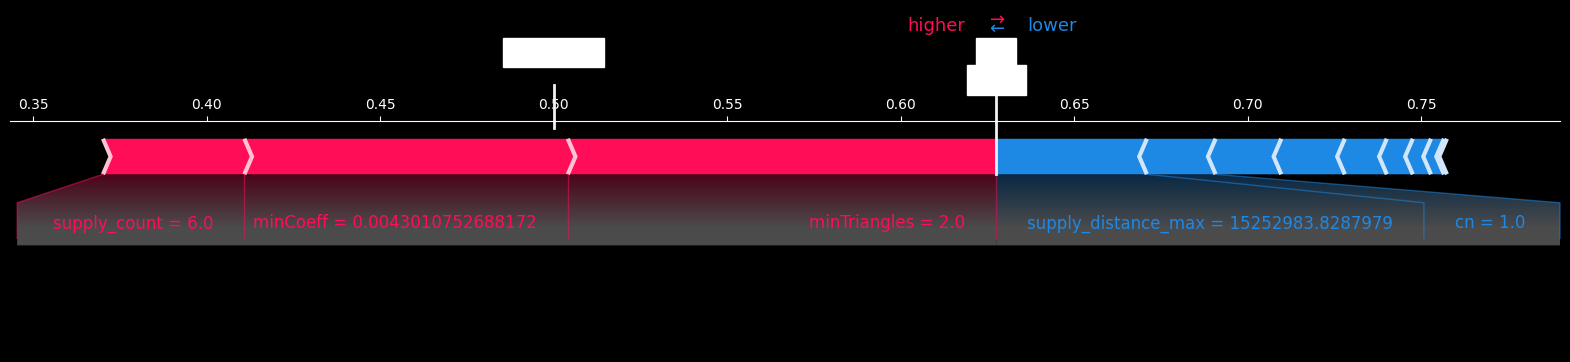

In [ ]:
# Calculate Shap values
choosen_instance = test1[columns].loc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, matplotlib=True)